Description:
* Exploring and analyzing a time series dataset about stocks
* 2 Datasets: QQQ and SPY daily stock info from late 90s to 4/10/2024
* Columns include: date, open, high, low, close, volume, and simple moving averages (5, 10, 20, 50, 100, 200 day)
* Will be using linear regression and other methods to try and predict future prices 

In [2]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [4]:
qqq = pd.read_csv('data\QQQ_1D_6sma.csv')
spy = pd.read_csv('data\SPY_1D_6sma.csv')

new_names = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200']
to_rename = ['MA', 'MA.1', 'MA.2', 'MA.3', 'MA.4', 'MA.5']

qqq.rename(columns = dict(zip(to_rename, new_names)), inplace = True)
spy.rename(columns = dict(zip(to_rename, new_names)), inplace = True)

spy.head()

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,Volume
0,1995-01-16,46.71875,47.03125,46.71875,47.01562,45.862263,46.358123,45.997186,46.085154,46.217185,46.449996,105100
1,1995-01-17,46.92187,47.06250,46.85937,47.03125,45.874450,46.357029,45.999061,46.149217,46.342185,46.628122,89500
2,1995-01-18,47.00000,47.07812,46.87500,46.98437,45.889841,46.356717,46.012186,46.207810,46.440622,46.790622,84500
3,1995-01-19,46.82812,46.87500,46.68750,46.71875,45.899372,46.347029,46.017186,46.260154,46.512497,46.896872,139100
4,1995-01-20,46.65625,46.67187,46.45312,46.54687,45.908044,46.335935,46.011561,46.279685,46.562497,46.859372,78700


# General EDA

In [6]:
# Check for nulls
qqq.isna().any(axis = None)

False

In [8]:
# Trying to plot the monthly performance over time
# Need to group by the month in to have a more legible plot

# Convert to datetime so it is more malleable
qqq.time = pd.to_datetime(qqq.time)
spy.time = pd.to_datetime(spy.time)

# Grouping by last trading of the month
qqq_monthly = qqq.groupby(qqq['time'].dt.to_period('M')).last()
spy_monthly = spy.groupby(spy['time'].dt.to_period('M')).last()

qqq_monthly

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,sma_200,Volume
time,,,,,,,,,,,,
1999-12,1999-12-31,92.62500,93.18750,91.3750,91.375,61.475820,68.309843,75.905781,84.562109,89.040625,90.850000,14453204
2000-01,2000-01-31,85.87500,90.00000,83.5000,90.000,65.208125,74.560625,85.261719,90.519140,92.118750,89.781250,36012192
2000-02,2000-02-29,105.75000,107.09375,104.9375,107.000,69.861836,82.268203,94.091094,100.188281,102.515625,105.112500,23975000
2000-03,2000-03-31,108.14062,110.62500,104.0000,109.500,76.588554,93.200390,103.840625,111.478906,112.660937,111.921874,31348896
2000-04,2000-04-28,93.56250,94.75000,92.1250,94.500,79.990664,96.737031,103.043750,94.246093,88.512500,89.737500,24826704
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12,2023-12-29,411.28000,411.64000,407.5800,409.520,359.354700,375.053500,383.472600,400.826500,408.401000,410.316000,42662120
2024-01,2024-01-31,420.85000,422.86990,416.7900,416.970,369.837000,384.407000,403.878600,413.599500,422.579000,424.116000,64010649
2024-02,2024-02-29,438.23000,440.09000,435.0200,439.000,381.124550,398.026200,420.008000,432.357500,434.128000,437.040000,42495152


In [70]:
print(f'QQQ\n{qqq.describe()}')
print('\n\nSpy')
print(spy.describe())

QQQ
                                time         open         high          low  \
count                           6113  6113.000000  6113.000000  6113.000000   
mean   2012-02-16 03:14:48.663504128   118.038526   118.998855   116.985428   
min              1999-12-22 00:00:00    19.940000    20.530000    19.759990   
25%              2006-01-23 00:00:00    41.810000    42.140000    41.330000   
50%              2012-02-15 00:00:00    68.330000    68.700000    67.840000   
75%              2018-03-14 00:00:00   161.330000   162.905000   160.090000   
max              2024-04-10 00:00:00   448.880000   449.340000   445.670000   
std                              NaN   106.176348   106.942505   105.359086   

             close        sma_5       sma_10       sma_20       sma_50  \
count  6113.000000  6113.000000  6113.000000  6113.000000  6113.000000   
mean    118.047752   112.436620   115.128782   116.590424   117.488098   
min      20.060000    24.604750    23.600400    22.701400    2

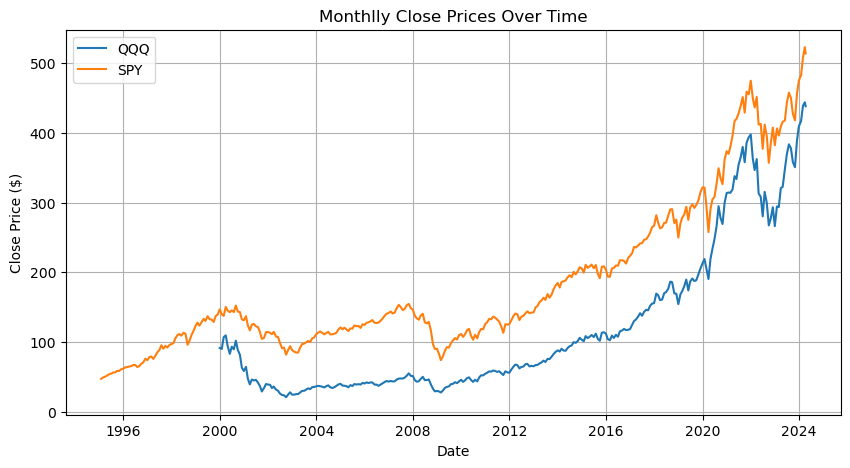

In [71]:
# Plotting the performance over time

plt.figure(figsize = (10,5))

plt.plot(qqq_monthly['time'], qqq_monthly['close'], label = 'QQQ')
plt.plot(spy_monthly['time'], spy_monthly['close'], label = 'SPY')
plt.title('Monthlly Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.grid(True)
plt.legend()

plt.show()

# Feature Engineering

In [10]:
qqq.columns

Index(['time', 'open', 'high', 'low', 'close', 'sma_5', 'sma_10', 'sma_20',
       'sma_50', 'sma_100', 'sma_200', 'Volume'],
      dtype='object')

In [12]:
# Slope of each sma over different periods

# Translate datetime data into a numeric data type
qqq['days_since_start'] = (qqq['time'] - qqq['time'].min()).dt.days
spy['days_since_start'] = (spy['time'] - spy['time'].min()).dt.days

# Slope of sma
sma_cols = ['sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200']
for sma in sma_cols:
    qqq[sma + '_1D_slope'] = qqq[sma].diff()
    spy[sma + '_1D_slope'] = spy[sma].diff()

# The slopes for the first entry will have NaN, replace with 0
qqq = qqq.fillna(0)
spy = spy.fillna(0)

In [14]:
# Range between high and low - volatlity in the price swings
qqq['range_hi_lo'] = qqq['high'] - qqq['low']
spy['range_hi_lo'] = spy['high'] - spy['low']

# range as a percentage of the close
qqq['range_%close'] = qqq['range_hi_lo']/qqq['close']
spy['range_%close'] = spy['range_hi_lo']/spy['close']

# 
qqq

,time,open,high,low,close,sma_5,sma_10,sma_20,sma_50,sma_100,...,Volume,days_since_start,sma_5_1D_slope,sma_10_1D_slope,sma_20_1D_slope,sma_50_1D_slope,sma_100_1D_slope,sma_200_1D_slope,range_hi_lo,range_%close
0,1999-12-22,89.187500,89.31250,87.43750,89.15625,60.300976,66.182031,72.281406,80.271875,82.964844,...,22313602,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.87500,0.021030
1,1999-12-23,89.867185,90.75000,89.00000,89.65625,60.492695,66.517890,72.848281,80.882812,84.030469,...,17542000,1,0.191719,0.335859,0.566875,0.610938,1.065625,1.30625,1.75000,0.019519
2,1999-12-27,90.312500,93.57031,87.90625,89.68750,60.690820,66.864218,73.408125,81.482812,85.049219,...,19282796,5,0.198125,0.346328,0.559844,0.600000,1.018750,1.18125,5.66406,0.063153
3,1999-12-28,89.750000,90.50000,88.56250,89.18750,60.879257,67.196796,73.994375,82.121875,85.868750,...,15345398,6,0.188437,0.332578,0.586250,0.639063,0.819531,0.86250,1.93750,0.021724
4,1999-12-29,90.000000,92.50000,89.87500,92.50000,61.082070,67.568515,74.662031,83.046875,87.165625,...,16512398,7,0.202813,0.371719,0.667656,0.925000,1.296875,0.76250,2.62500,0.028378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6108,2024-04-04,446.330000,446.95000,435.11000,435.34000,392.362000,417.194400,435.787000,441.566000,443.267000,...,57267660,8870,0.337050,0.624000,0.237200,-0.172500,-0.843000,-1.89800,11.84000,0.027197
6109,2024-04-05,436.780000,443.17000,435.96000,440.47000,392.729850,417.898400,436.079800,441.317000,442.727000,...,54744634,8871,0.367850,0.704000,0.292800,-0.249000,-0.540000,-0.70800,7.21000,0.016369
6110,2024-04-08,441.410000,442.50000,439.20000,440.60000,393.123350,418.520500,436.364800,441.396000,442.149000,...,28144944,8874,0.393500,0.622100,0.285000,0.079000,-0.578000,-0.87000,3.30000,0.007490
6111,2024-04-09,442.960000,443.24000,437.44000,442.23000,393.503650,419.170700,436.733200,441.638000,441.896000,...,39521568,8875,0.380300,0.650200,0.368400,0.242000,-0.253000,0.22400,5.80000,0.013115


# Model - linear regression

In [139]:
class stock_LR:
    def __init__(self,stock):
        self.stock = stock
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred = None
        self.rmse = None
        self.score = None
        from sklearn.linear_model import LinearRegression
        from sklearn.metrics import mean_squared_error
        
    def linReg(self, column, split): # column will be whatever column/feature you want to choose as your x-variable
        LR = LinearRegression()

        # .fit() expects 2D array
        # (-1,1) in the rows tells numpy to automatically calculate the number of rows needed
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.stock[column].values.reshape(-1,1), 
                                                            self.stock.close, 
                                                            test_size = split, 
                                                            random_state = 50)
        LR.fit(self.x_train, self.y_train)
        
        self.y_pred = LR.predict(self.x_test)

        self.rmse = np.sqrt(mean_squared_error(y_true = self.y_test, y_pred = self.y_pred)) 
        # .score() uses coefficient of determination R^2
        self.score = LR.score(self.x_test, self.y_test)
        
        # print(f'Root Mean Squared Error: {rmse}\nCoefficient: {LR.coef_[0]}\nIntercept: {LR.intercept_}')
        return([self.rmse, self.score, LR.coef_[0], LR.intercept_])

In [73]:

# qqq['time_since_start'] = (qqq['time'] - qqq['time'].min()).dt.days
# spy['time_since_start'] = (spy['time'] - spy['time'].min()).dt.days

# qqq_LR = stock_LR(qqq)
# spy_LR = stock_LR(spy)

# print('x = time_since_start\nQQQ:')
# qqq_LR.linReg('time_since_start')
# print('\nSPY:')
# spy_LR.linReg('time_since_start')

In [151]:
spy.columns

Index(['time', 'open', 'high', 'low', 'close', 'sma_5', 'sma_10', 'sma_20',
       'sma_50', 'sma_100', 'sma_200', 'Volume', 'days_since_start',
       'sma_5_1D_slope', 'sma_10_1D_slope', 'sma_20_1D_slope',
       'sma_50_1D_slope', 'sma_100_1D_slope', 'sma_200_1D_slope'],
      dtype='object')

In [152]:
# Initiate the classes
qqq_LR = stock_LR(qqq)
spy_LR = stock_LR(spy)

# List of all features to be used and compared
features = ['open', 'high', 'low', 'sma_5', 'sma_10', 'sma_20',
       'sma_50', 'sma_100', 'sma_200', 'Volume', 'days_since_start',
       'sma_5_1D_slope', 'sma_10_1D_slope', 'sma_20_1D_slope',
       'sma_50_1D_slope', 'sma_100_1D_slope', 'sma_200_1D_slope']

qqq_lr_results = {}
spy_lr_results = {}

# Using a 80/20 split
for col in features:
    qqq_res = qqq_LR.linReg(col, 0.2)
    spy_res = spy_LR.linReg(col, 0.2)

    qqq_lr_results[col] = qqq_res
    spy_lr_results[col] = spy_res

qqq_lr_df = pd.DataFrame(qqq_lr_results).transpose()
spy_lr_df = pd.DataFrame(spy_lr_results).transpose()

new_cols = ['rmse', 'score', 'coefficient', 'intercept']

qqq_lr_df.columns = new_cols
spy_lr_df.columns = new_cols

print(f'Best x var RMSE (QQQ): {qqq_lr_df.rmse.idxmin(), qqq_lr_df.rmse.min()}')
print(f'Best x var RMSE (SPY): {spy_lr_df.rmse.idxmin(), spy_lr_df.rmse.min()}')
print(f'Best x var Score (QQQ): {qqq_lr_df.score.idxmax(), qqq_lr_df.score.max()}')
print(f'Best x var Score (SPY): {spy_lr_df.score.idxmax(), spy_lr_df.score.max()}')

Best x var RMSE (QQQ): ('low', 1.2858301892841237)
Best x var RMSE (SPY): ('low', 1.2113128095247747)
Best x var Score (QQQ): ('low', 0.9998621370355871)
Best x var Score (SPY): ('low', 0.9998748592855212)


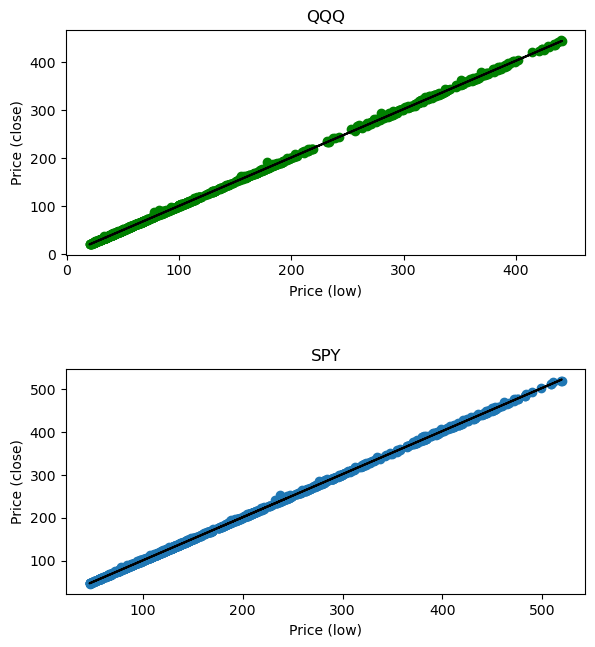

In [168]:
# Graphing best result
qqq_LR.linReg('low', 0.2)
spy_LR.linReg('low', 0.2)

fig, axs = plt.subplots(2,1)
axs[0].scatter(qqq_LR.x_test, qqq_LR.y_test, color = 'g')
axs[0].plot(qqq_LR.x_test, qqq_LR.y_pred, color = 'black')
axs[1].scatter(spy_LR.x_test, spy_LR.y_test)
axs[1].plot(spy_LR.x_test, spy_LR.y_pred, color = 'black')

axs[0].set_xlabel('Price (low)')
axs[0].set_ylabel('Price (close)')
axs[0].set_title('QQQ')

axs[1].set_xlabel('Price (low)')
axs[1].set_ylabel('Price (close)')
axs[1].set_title('SPY')

plt.tight_layout()

fig.set_figheight(7)
fig.set_figwidth(6)

# Model - Ensemble: Random Forest Regressor

In [284]:
# train test split 80/20

qqq_x_train, qqq_x_test, qqq_y_train, qqq_y_test = train_test_split(qqq, qqq.close, test_size = 0.2)
spy_x_train, spy_x_test, spy_y_train, spy_y_test = train_test_split(spy, spy.close, test_size = 0.2)

In [233]:
start = time.time()

def clf_performance(regressor, model_name): # Borrowing from Ken Jee
    print(f"\n{model_name}")
    print('Best Score: ' + str(regressor.best_score_))
    print('Best Parameters: ' + str(regressor.best_params_))

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [50, 100, 250, 500, 750, 1000],
    'bootstrap': [True, False],
    'max_depth': [3, 5, 10, 20, 50, 75, 100, None],
    'max_features': ['log2', 'sqrt', 10, 50, 100, 200, 300],
    'min_samples_leaf': [1, 2, 4, 10],
    'min_samples_split': [2, 5, 10]
}

clf_rf_rnd = RandomizedSearchCV(rf, param_distributions=param_grid, n_iter=200, cv=5, verbose=True, n_jobs=-1)
best_clf_rf_rnd = clf_rf_rnd.fit(qqq_x_train, qqq_y_train)
clf_performance(best_clf_rf_rnd, 'Random Forest Regressor')

end = time.time()
print(f'Total time elapse: {end - start}')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits

Random Forest Regressor
Best Score: 0.99986980704629
Best Parameters: {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 10, 'max_depth': 100, 'bootstrap': True}
Total time elapse: 1411.8825869560242


In [292]:
start = time.time()

qqq_rfreg = RandomForestRegressor(n_estimators = 250, min_samples_split= 2, min_samples_leaf= 1, max_features= 10, max_depth= 100, bootstrap= True)
spy_rfreg = RandomForestRegressor(n_estimators = 250, min_samples_split= 2, min_samples_leaf= 1, max_features= 10, max_depth= 100, bootstrap= True)

# training on all columns except target column (close) and the time column (converted it to a continuous variable: days_since_start)
feature_cols = [col for col in qqq.columns if col != 'close' and col != 'time']

qqq_rfreg.fit(qqq_x_train[feature_cols], qqq_y_train)
spy_rfreg.fit(spy_x_train[feature_cols], spy_y_train)

# Creating a dataframe for evaluation and graphing purposes
qqq_rfreg_test = qqq_x_test.copy()
qqq_rfreg_test['predict_close'] = qqq_rfreg.predict(qqq_x_test[feature_cols])

spy_rfreg_test = spy_x_test.copy()
spy_rfreg_test['predict_close'] = spy_rfreg.predict(spy_x_test[feature_cols])

# Model evaluation
qqq_rfreg_mse = mean_squared_error(qqq_rfreg_test['close'], qqq_rfreg_test['predict_close'])
qqq_rfreg_r2 = r2_score(qqq_rfreg_test['close'], qqq_rfreg_test['predict_close'])

spy_rfreg_mse = mean_squared_error(spy_rfreg_test['close'], spy_rfreg_test['predict_close'])
spy_rfreg_r2 = r2_score(spy_rfreg_test['close'], spy_rfreg_test['predict_close'])

print(f'Random Forest Regressor')
print(f'\nQQQ Mean Squared Error:{qqq_rfreg_mse}\nQQQ R squared: {qqq_rfreg_r2}')
print(f'\nSPY Mean Squared Error:{spy_rfreg_mse}\nSPY R squared: {spy_rfreg_r2}')

end = time.time()
print(f'\nTotal time elapse: {(end - start)/60} min')

Random Forest Regressor

QQQ Mean Squared Error:1.347199336568001
QQQ R squared: 0.9998825327504284

SPY Mean Squared Error:1.3718028541270102
SPY R squared: 0.9998890978863509

Total time elapse: 0.3812063455581665 min


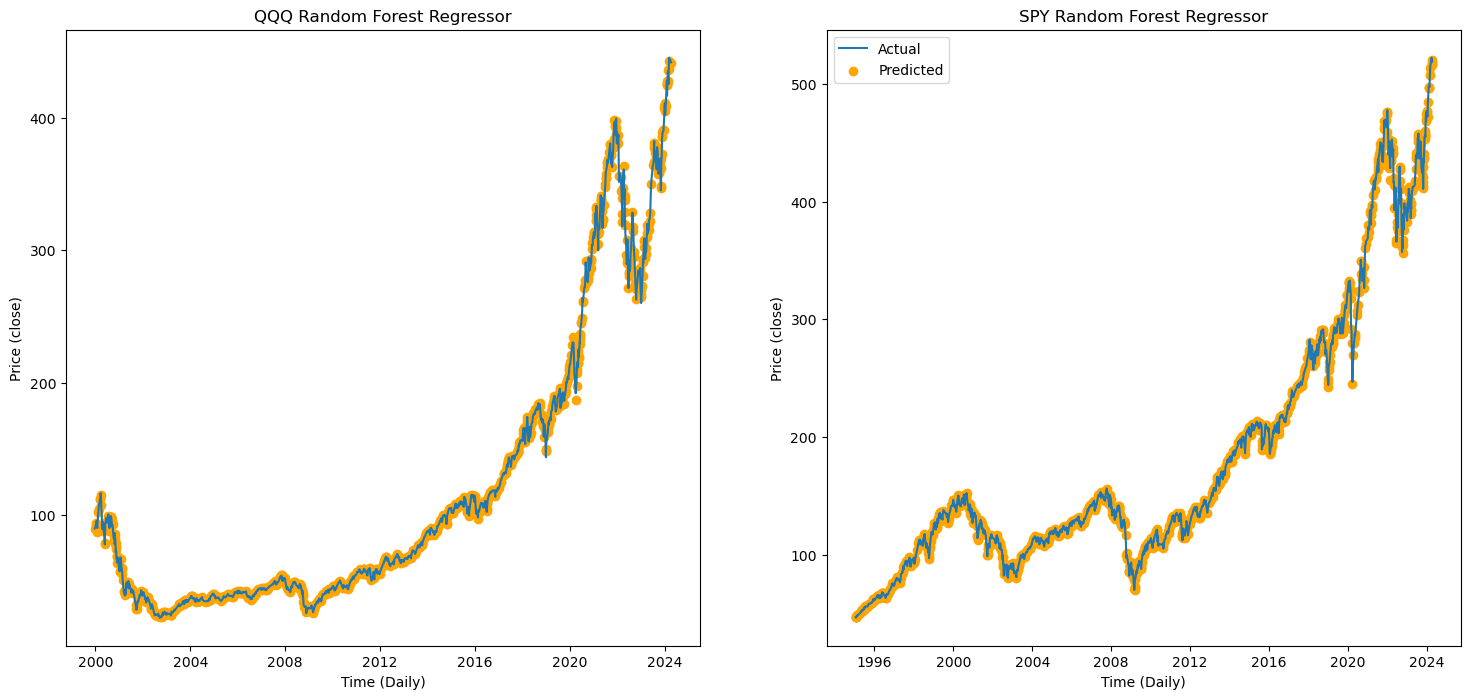

In [310]:
qqq_rfreg_test = qqq_rfreg_test.sort_values('time')
spy_rfreg_test = spy_rfreg_test.sort_values('time')

fig, axs = plt.subplots(1,2)

axs[0].plot(qqq_rfreg_test['time'], qqq_rfreg_test['close'], label = 'Actual')
axs[0].scatter(qqq_rfreg_test['time'], qqq_rfreg_test['predict_close'], color = 'orange', label = 'Predicted')
axs[1].plot(spy_rfreg_test['time'], spy_rfreg_test['close'], label = 'Actual')
axs[1].scatter(spy_rfreg_test['time'], spy_rfreg_test['predict_close'], color = 'orange', label = 'Predicted')

axs[0].set_xlabel('Time (Daily)')
axs[0].set_ylabel('Price (close)')
axs[0].set_title('QQQ Random Forest Regressor')

axs[1].set_xlabel('Time (Daily)')
axs[1].set_ylabel('Price (close)')
axs[1].set_title('SPY Random Forest Regressor')

plt.legend()

fig.set_figheight(8)
fig.set_figwidth(18)

# Model - Gradient Boosting (XGBoost)

# Model - Support Vector Machines

# Model - LSTM network

# Model - GRU

# Model - CNN 